# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import datetime
import time
import pandas as pd
import numpy as np
import re

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline



In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify Capstone Project").getOrCreate()

In [3]:
#check spark version
spark

In [4]:
#check spark config's
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1629865356002'),
 ('spark.app.name', 'Sparkify Capstone Project'),
 ('spark.driver.port', '43687'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', 'fe1763e78f0a'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

This workspace dataset containes a tiny subset (128MB) of the full dataset available(12GB).

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
#Check Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
#Number of records
print("Number of Records : ",df.count())
print("Number of Columns : ",len(df.columns))

Number of Records :  286500
Number of Columns :  18


In [8]:
#Sample dataset
#Using pandas to better visualization
df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
# Check for null values or any missing values for ID columns
#Shows number os null values in each columns
df_nulls = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


It looks like that userID columns does not have any null values but useragent has 8346 null. Let's investigate further to see if any empty or missing userId's.

In [10]:
#Count empty userID's
print("Empty userID counts : ", df.filter(df["userId"] == "").count())
print("Empty sessionId counts : ", df.filter(df["sessionId"] == "").count())

Empty userID counts :  8346
Empty sessionId counts :  0


In [11]:
#Show number of duplicated columns
df.groupBy(df.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [12]:
df =  df.filter(df["userId"] != "")

In [13]:
#Checking null values agian
df_nulls = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


In [14]:
#Number of records
print("Number of Records : ",df.count())
print("Number of Columns : ",len(df.columns))

Number of Records :  278154
Number of Columns :  18


In [15]:
#Convert TS to human readable
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('ts', convert_ts('ts'))
df = df.withColumn('registration', convert_ts('registration'))
df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Rockpools,200,2018-10-01 00:01:57,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Canada,200,2018-10-01 00:03:00,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Time For Miracles,200,2018-10-01 00:06:34,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Knocking On Forbidden Doors,200,2018-10-01 00:06:56,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Harder Better Faster Stronger,200,2018-10-01 00:11:16,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Don't Leave Me,200,2018-10-01 00:11:18,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Run Run Run,200,2018-10-01 00:14:46,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Passengers (Old Album Version),200,2018-10-01 00:14:59,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,2018-09-28 22:22:42,29,None,200,2018-10-01 00:15:05,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Fuck Kitty,200,2018-10-01 00:18:04,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [16]:
# Add duration to the dataset
df = df.withColumn("register_duration", F.datediff(F.col('ts'), F.col('registration')))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [17]:
#Lets look at page column to see membership status
df.groupBy("page").agg(count("userId")).toPandas()

,page,count(userId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,10082
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,495


In [18]:
#Lets look at cancel and cancellation confirmation smaple data
cancel_events = df.filter(F.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_events.show(10, False)

+------+-------------------------+---------+--------+-------------------+---------+
|userID|page                     |firstName|lastName|ts                 |auth     |
+------+-------------------------+---------+--------+-------------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |2018-10-07 20:22:20|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |2018-10-07 20:26:30|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |2018-10-08 21:10:31|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |2018-10-08 21:10:46|Cancelled|
|125   |Cancel                   |Mason    |Hart    |2018-10-12 04:35:18|Logged In|
|125   |Cancellation Confirmation|Mason    |Hart    |2018-10-12 04:35:18|Cancelled|
|105   |Cancel                   |Alexander|Garcia  |2018-10-12 20:16:18|Logged In|
|105   |Cancellation Confirmation|Alexander|Garcia  |2018-10-12 20:17:21|Cancelled|
|17    |Cancel                   |Kayla    |Johnson |2018-10-13 21:17:31|Log

In [19]:
#Based on that user's who went to cancel page more likely to cancel their subscription.


In [20]:
#Let see downgraded customers behaviour
cancel_reg_ids  = [cc['userID'] for cc in cancel_events.select('userID').collect()]
print("Unique Cancelled ID's : ",len(set(cancel_reg_ids)))

Unique Cancelled ID's :  52


In [21]:
#customer who downgraded
downgrade_events = df.filter(F.col('page').isin(['Downgrade']))
downgrade_events.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+---------+---------+--------+-------------------+---------+
|userID|page     |firstName|lastName|ts                 |auth     |
+------+---------+---------+--------+-------------------+---------+
|54    |Downgrade|Alexi    |Warren  |2018-10-01 00:45:49|Logged In|
|95    |Downgrade|Faigy    |Howe    |2018-10-01 05:54:46|Logged In|
|95    |Downgrade|Faigy    |Howe    |2018-10-01 11:16:52|Logged In|
|131   |Downgrade|Kael     |Baker   |2018-10-01 11:33:38|Logged In|
|95    |Downgrade|Faigy    |Howe    |2018-10-01 11:34:24|Logged In|
+------+---------+---------+--------+-------------------+---------+
only showing top 5 rows



In [22]:
#See downgraded ID's
downgrade_reg_ids = [dg['userID'] for dg in downgrade_events.select('userID').collect()]
print("Unique downgrade ID's : ",len(set(downgrade_reg_ids)))

Unique downgrade ID's :  154


In [23]:
#Now see % of downgraded users also cancelled their subscription
down_cancel = set(cancel_reg_ids).intersection((set(downgrade_reg_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(down_cancel))/len(set(downgrade_reg_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


## Define Churn
The above analysis shows that Cancel is followed by cancellation confirmation page and both indicate user is canceling thier subscreption unless they change thier mind once they are on the cancel page which seems unlikely event at least for this dataset. So we will use both of these events to define Churn. We have also seen that about 23% of the customers who downgraded have also cancelled thier subscription. However, we'll exclude those who downgraded but didn't cancel yet for this analysis even thought they seem candidates who will eventually cancel their subscription.


In [24]:
#
# find the user_id of the churned users
churned_users = (df.filter(df.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()
                       .rdd.flatMap(lambda x: x)
                       .collect())

In [25]:
# df = df.withColumn('churn', F.when(col('page')=='Cancellation Confirmation', 1).when(col('page')=='Cancel', 1).otherwise(0))
df = df.withColumn('churn', when(df.userId.isin(churned_users), 1).otherwise(0))

In [26]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- register_duration: integer (nullable = true)
 |-- churn: integer (nullable = false)



In [27]:
df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,register_duration,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Rockpools,200,2018-10-01 00:01:57,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Canada,200,2018-10-01 00:03:00,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Time For Miracles,200,2018-10-01 00:06:34,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Knocking On Forbidden Doors,200,2018-10-01 00:06:56,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Harder Better Faster Stronger,200,2018-10-01 00:11:16,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Don't Leave Me,200,2018-10-01 00:11:18,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 18:20:30,8,Run Run Run,200,2018-10-01 00:14:46,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Passengers (Old Album Version),200,2018-10-01 00:14:59,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,2018-09-28 22:22:42,29,None,200,2018-10-01 00:15:05,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 22:22:42,29,Fuck Kitty,200,2018-10-01 00:18:04,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,3,0


In [28]:
df.groupBy("page").agg(count("userId")).toPandas()

,page,count(userId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,10082
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,495


## Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [29]:
#Number of customers churned

In [30]:
df_churn = df.groupBy('churn').agg(F.countDistinct('userId').alias('count'))
# convert to pandas for visualisation
df_churn = df_churn.toPandas()

In [31]:
df_churn

,churn,count
0,1,52
1,0,173


Text(0.5,1,'Number of churned users Vs no churned')

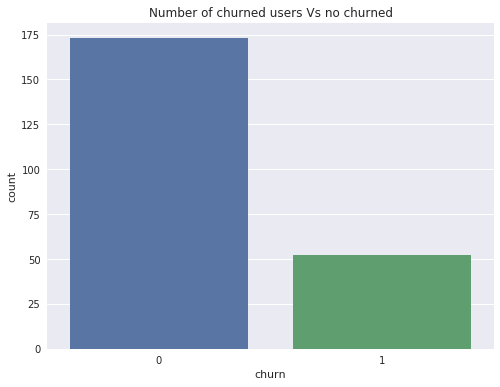

In [32]:
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Number of churned users Vs no churned")

In [33]:
# calculate churn rate
print("Churn Rate : ", df.select('userID').filter(F.col('churn') == 1).distinct().count()/df.select("userID").distinct().count() * 100)


Churn Rate :  23.11111111111111


So we know among these 225 userIds, 52 users churn and 173 users stay, the churn rate is about 23%

In [34]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- register_duration: integer (nullable = true)
 |-- churn: integer (nullable = false)



churn  gender
0      F         84
       M         89
1      F         20
       M         32
Name: userId, dtype: int64


Text(0.5,1,'Churn by Gender distribution')

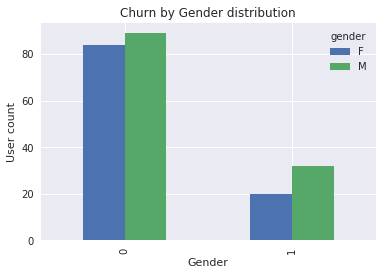

In [35]:
# Distribution by gender
df1 = df.toPandas()
df_gender = df1.groupby(['churn', 'gender'])['userId'].nunique().unstack()
print(df1.groupby(['churn', 'gender'])['userId'].nunique())
df_gender.plot(kind = 'bar', legend = True)
plt.ylabel("User count")
plt.xlabel("Gender")
plt.title("Churn by Gender distribution")

churn  level
0      free     149
       paid     129
1      free      46
       paid      36
Name: userId, dtype: int64


Text(0.5,1,'Churn by subscription level')

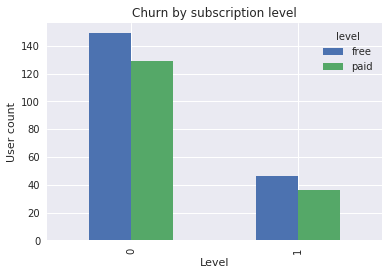

In [36]:
# Churn distribution by level
df_level = df1.groupby(['churn', 'level'])['userId'].nunique().unstack()
print(df1.groupby(['churn', 'level'])['userId'].nunique())
df_level.plot(kind = 'bar', legend = True)
plt.ylabel("User count")
plt.xlabel("Level")
plt.title("Churn by subscription level")

Text(0,0.5,'Frequency')

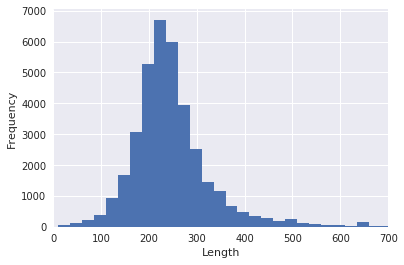

In [37]:
## Length of time: Users that Churned vs. Users that Stayed
df_pd = df.filter(df.churn ==1).toPandas()
# drop the nulls
df_pd.length.dropna(inplace=True)
# plot the distribution
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

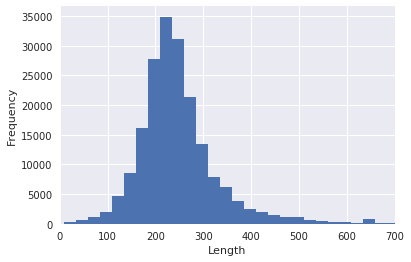

In [38]:
#Repeat above steps for active users
df_pd = df.filter(df.churn ==0).toPandas()
# drop the nulls
df_pd.length.dropna(inplace=True)
# plot the distribution
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency')

We can see from the above plots that length distribution is very similar for users that churned and those who stayed. This won't be very useful for predicting customer churn. Let's try a categorical feature: gender.
        

In [39]:
# Distribution by Page
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()
df_page.toPandas()

,page,churn,count
0,Thumbs Up,0,10692
1,Upgrade,0,387
2,Logout,0,2673
3,Upgrade,1,112
4,Add Friend,1,636
5,Error,1,32
6,Home,1,1672
7,NextSong,0,191714
8,Submit Upgrade,0,127
9,Help,0,1215


In [40]:
# convert to pandas
df_page = df_page.toPandas()
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()


# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count']))

df_page.head(40)

,page,churn,count,rate
0,Thumbs Up,0,10692,0.045831
1,Upgrade,0,387,0.001659
2,Logout,0,2673,0.011458
3,Upgrade,1,112,0.002496
4,Add Friend,1,636,0.014176
5,Error,1,32,0.000713
6,Home,1,1672,0.037268
7,NextSong,0,191714,0.821784
8,Submit Upgrade,0,127,0.000544
9,Help,0,1215,0.005208


Text(0.5,1,'Rate of Pages Navigated to by Users')

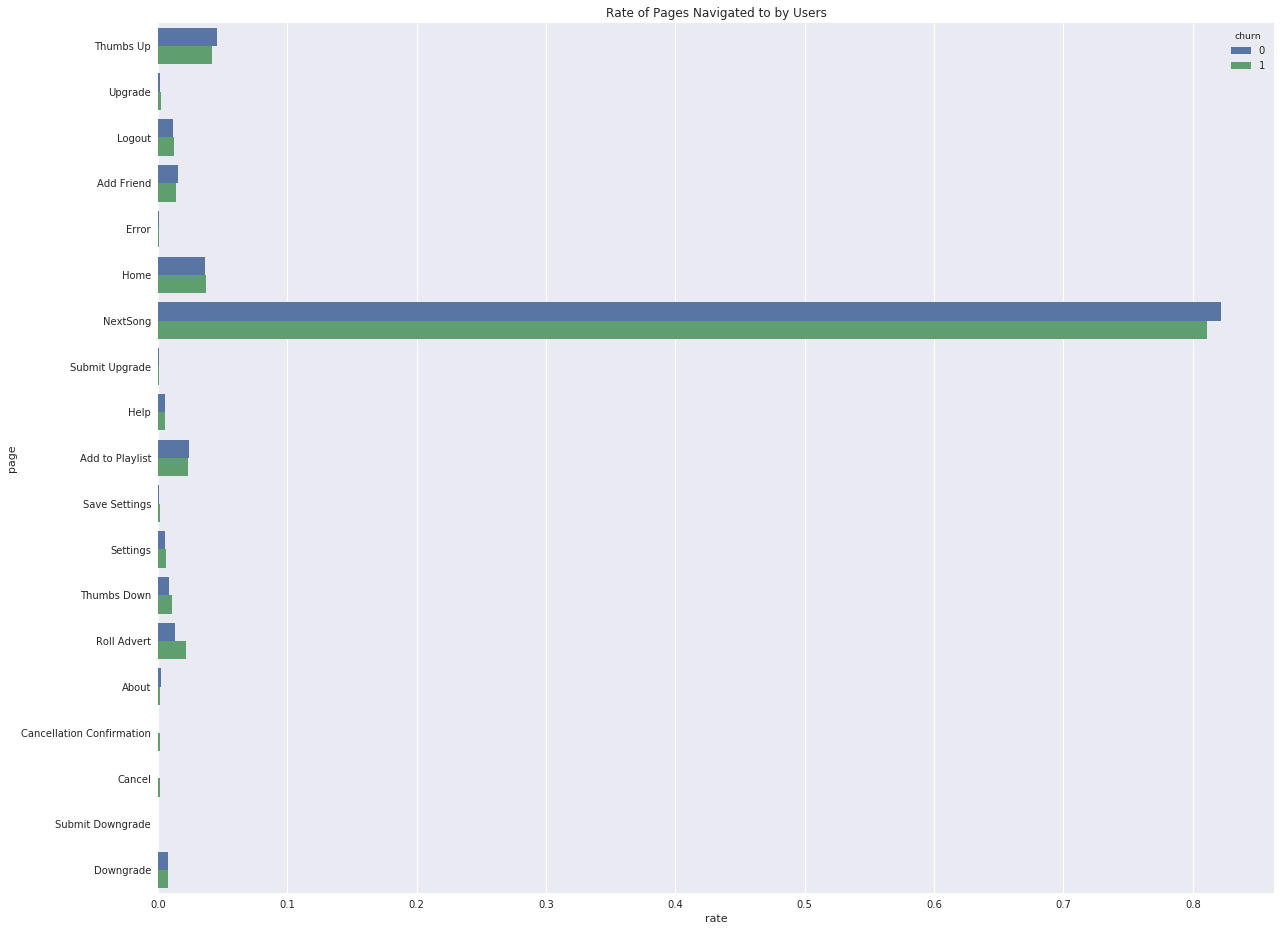

In [41]:
# plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users')

From the above chart, we can see that the most popular action for both users that stayed and those that churned was to skip to the next song. We can also see that churned users rolled the ad and thumbs down songs more. Those who were more likely to stay performed more thumbs up actions, added friends and also added songs to playlist.

Text(0,0.5,'Days Since Registered')

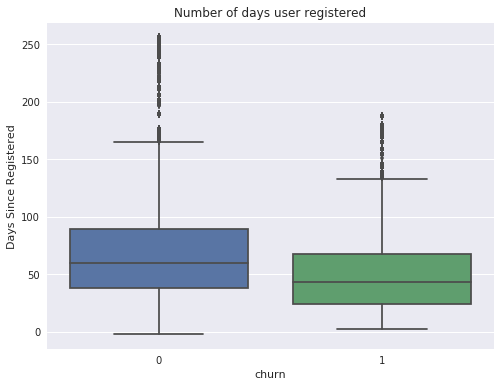

In [42]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df1, x = 'churn', y ='register_duration')
plt.title('Number of days user registered')
plt.ylabel("Days Since Registered")

An average those who had been registered with Sparkify for longer were more likely to stay. Users who had registered more recently were more likely to churn.


# Feature Engineering
Now that EDA has been performed, we can build out the features that seem most promising to train our model on.
The features we will build out are:
1. Average Number of songs per session
2. Registered Duration
3. Total Songs
4. Number of rollads actions
5. Number of thumbs up actions
6. Number of thumbs down actions
7. Number of friends added
8. Number of Songs added to playlist
9. Gender
10. Premium Level
11. Churn Flag

We will also then add a churn label and join these all together. This will create a dataFrame where each row represents information pertaining to each individual user. Once we drop the userId, this dataframe can be vectorised, standarised and fed into our different machine learning algorithms.


In [43]:
# 1. Average Number of songs per session
avg_song = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [44]:
avg_song = avg_song.groupby('userId').agg({"count":"avg"})
avg_song = avg_song.withColumnRenamed("avg(count)", "avg_song")


In [45]:
# 2. Registered Duration
register_days = df.select(['userId', 'registration', 'ts', 'churn', 'register_duration']).dropDuplicates().sort('userId')

# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))
# create a rank with the most recent timestamp as rank number 1
register_days = register_days.withColumn("Rank", dense_rank().over(w))

# just get those with a rank of 1 i.e the first rows
register_days = register_days.filter(register_days.Rank == 1).drop(register_days.Rank)

register_days = register_days.select(['userId', 'register_duration']).dropDuplicates()


In [46]:
# 3. Total Songs
total_song = df.filter(df.page == "NextSong").groupBy('userId').count()
total_song = total_song.groupby('userId').agg({"count":"sum"})
total_song = total_song.withColumnRenamed("sum(count)", "total_songs_count")

In [47]:
# 4. Number of rollads actions
# Next feature we can consider is number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.
roll_adv = df.select(["userId", "page"])
add_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

roll_adv = roll_adv.withColumn("rollad", add_event("page"))
roll_adv = roll_adv.groupby('userId').sum("rollad")

roll_adv = roll_adv.withColumnRenamed("sum(rollad)", "roll_ad")



In [48]:
# 5. Number of thumbs up actions
#  Users who stayed with the service had performed more thumbs up actions in the past.
thumbup = df.select(["userId", "page"])
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbup = thumbup.withColumn("Thumbs Up", thumbup_event("page"))

thumbup = thumbup.groupby('userId').sum("Thumbs Up")
thumbup = thumbup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")


In [49]:
# 6. Number of thumbs down actions
thumbdown = df.select(["userId", "page"])
thumbdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbdown = thumbdown.withColumn("Thumbs Down", thumbdown_event("page"))

thumbdown = thumbdown.groupby('userId').sum("Thumbs Down")
thumbdown = thumbdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")


In [50]:
# 7. Number of friends added
add_frnd = df.select(["userId", "page"])
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

add_frnd = add_frnd.withColumn("add_friend", add_friend("page"))
add_frnd = add_frnd.groupby('userId').sum("add_friend")

add_frnd = add_frnd.withColumnRenamed("sum(add_friend)", "no_of_add_friend")



In [51]:
# 8. Number of Songs added to playlist
add_playlist = df.select(["userId", "page"])
add_friend = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

add_playlist = add_playlist.withColumn("Playlist", add_friend("page"))
add_playlist = add_playlist.groupby('userId').sum("Playlist")

add_playlist = add_playlist.withColumnRenamed("sum(Playlist)", "no_of_AddPlaylist")


In [52]:
# Categorical columns
# 9. Gender
#this is categorical columns so we need to lable the gender column-  female : 1, male : 0
gender = df.select(['userId', 'gender']).dropDuplicates()

# create gender column 
gender = gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [53]:
# 10. Premium Level
# This is another categorical columns so need to lable the level column-  paid : 1, free : 0
level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

#The level can change so we need to only take the most recent. We can use the rank trick from before.
w = Window.partitionBy("userId").orderBy(desc("ts"))

level = level.withColumn("Rank", dense_rank().over(w))

level = level.filter(level.Rank == 1).drop(level.Rank).drop('ts')
level = level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))


In [54]:
# 11.Churn Flag
# churn : 1 , no churn : 0
churn = df.select("userId", "churn").dropDuplicates()

# Creating Feature Dataset

In [55]:
# merging all above defined feature individual dataset into final df
feature_df = avg_song.join(total_song, on='userId')\
    .join(roll_adv, on='userId')\
    .join(thumbup, on='userId')\
    .join(thumbdown, on='userId')\
    .join(add_frnd, on='userId')\
    .join(add_playlist, on='userId')\
    .join(gender, on='userId')\
    .join(level, on='userId')\
    .join(churn, on='userId')\
    .join(register_days, on='userId').drop('userId')

feature_df = feature_df.drop_duplicates()

In [56]:
# Rechecking no's
feature_df.count()

225

Feature final dataset is complete; now we need to process the feature df for modelling.

In [57]:
#Print Schema
feature_df.printSchema()

root
 |-- avg_song: double (nullable = true)
 |-- total_songs_count: long (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- no_of_add_friend: long (nullable = true)
 |-- no_of_AddPlaylist: long (nullable = true)
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- churn: integer (nullable = false)
 |-- register_duration: integer (nullable = true)



In [58]:
#There are some columns not in numerical type; need to convert into numeric
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [59]:
#check again column type
feature_df.printSchema()

root
 |-- avg_song: float (nullable = true)
 |-- total_songs_count: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- no_of_add_friend: float (nullable = true)
 |-- no_of_AddPlaylist: float (nullable = true)
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- churn: float (nullable = false)
 |-- register_duration: float (nullable = true)



In [60]:
# Rechecking the counts
feature_df.count()

225

# Feature dataframe needs to be vectorised and Standardisation:

Vector assembler is used vectorise feature dataset; purpose of the assembler is to transform features into Vectors.
Once we have vectors then we can use that to standardize values so that features with the highest values don't dominate the results. Final dataset individual features will be normally distributed data.

In [61]:
#vector assembler
assembler = VectorAssembler(inputCols = ["avg_song", "total_songs_count", "roll_ad", "thumbs_up","thumbs_down", "no_of_add_friend", "no_of_AddPlaylist", "gender", "level","register_duration"], outputCol = "vec_features")
feature_df = assembler.transform(feature_df)

In [62]:
#StandardScaler
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(feature_df)
feature_df = scaler_model.transform(feature_df)

In [63]:
feature_df.head()

Row(avg_song=89.19999694824219, total_songs_count=2676.0, roll_ad=16.0, thumbs_up=118.0, thumbs_down=32.0, no_of_add_friend=40.0, no_of_AddPlaylist=77.0, gender=0.0, level=1.0, churn=0.0, register_duration=61.0, vec_features=DenseVector([89.2, 2676.0, 16.0, 118.0, 32.0, 40.0, 77.0, 0.0, 1.0, 61.0]), features=DenseVector([2.0931, 2.4218, 0.7425, 1.8021, 2.447, 1.9435, 2.3535, 0.0, 2.0844, 1.6212]))

In [64]:
# Rechecking the counts after vector and standardsclar
feature_df.count()

225

In [65]:
#Checking whether churn no's correct
feature_df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



## Split Dataset
    
  Final dataset can be devided into 3 different sets; training set, test set and validation set. Model get trained with training set, once it done it uses validation dataset to evaluate the metrics.

In [66]:
#Split the full dataset into train, test, and validation sets.
train, rest = feature_df.randomSplit([0.6, 0.4], seed=42)
valid, test = rest.randomSplit([0.5, 0.5], seed=42)

In [67]:
print("Training Set:" + str(train.count()))
print("Test Set:" + str(test.count()))
print("Validation Set:" + str(valid.count()))

Training Set:137
Test Set:63
Validation Set:25


# Modeling
Now dataset is ready, and I am using 3 different machine learning models to predict customer churn. 
Since Churn Prediction is classification problem, I am going to use classification algorithmw; user either churn or no churn in a certain period.

1. Random Forest Classifier:
     Random Forest is a powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. RF is also robust and has good performance on imbalanced datasets like we have here.
     
2. Logistic Regression:
    Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability. Logistic regression is also easy to implement, interpret and is efficient to train. It is also less inclined to overfitting.
    
3. Gradient-Boosted Tree Classifier:
     This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. It provides good accuracy, also perform well with unbalanced data.
     
     
## Metrics

Since the churned users are a fairly small subset, I am using F1 score as the metric to optimize. I will use multiclassclassificationevaluator to get the F1 score.

From these models I will be providing their results and evaluating their Accuracy and F1-Score. It is important for me to understand when my models are being as accurate as possible when determining when one of my users will possibly be churning and thus this is something that I will check against all models. However, Accuracy is not everything thus I must also make sure to not have a model that will potentially tell me a lot more users could possibly be churning when in reality they may not or there may be too many users showing possible churn. This could potentially lead to time wasted on users that are not churning and could mean extra costs for Sparkify. To balance this, I will be evaluating and optimizing the F1-Score which is a function of Precision and Recall to help give me the right balanced model.

## Model Implimentation

Steps involved in model implimentation:
1. Instansiate the model
2. Fit models
3. Predict the model
4. Evaluate the model

In [68]:
def model_Run(training_set, testing_set, validation_set):
    """
    This method is used to run given machine learning models and evaluates the F1 scores and accuracy.
    Based on this function output i am going to decide which model is the best model.
    
    args:
        training_set : Training set
        testing_set : Testing set
        validation_set : Validation set
    
    return:
        prints accuaracy and F1 scores for the givem machine machine learning model
    
    """
    from time import time
    
#     Instansiate
    lr = LogisticRegression(labelCol = 'churn', maxIter=10)
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn', seed=42)
    gbt = GBTClassifier(featuresCol = 'features', labelCol = 'churn', maxIter=10, seed=42)
    
    model_list = [lr, rf, gbt]
    
    #evaluator for F1 scorea and accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol = 'churn',metricName='f1')
    paramGrid = ParamGridBuilder().build()
    
    for model in model_list:
        model_name = model.__class__.__name__
    
        print(model_name, 'prediction started')
        crossval_val = CrossValidator(estimator=model, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

        # Metric calculation
        start_time = time()
        #fit model
        cvModel_fit = crossval_val.fit(train)
        end_time = time()
        cvModel_fit.avgMetrics
        #model prediction
        predictions = cvModel_fit.transform(valid)
        
        print("")
        print("------------------------------------------------")
        print(model_name, ' Metrics:')
        print("------------------------------------------------")
        print('Model Accuracy : {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
        print('Model F1 score :{}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
        print('Time taken for model is : {} seconds'.format(end_time- start_time))
        print("------------------------------------------------")
        
        print("")
        


In [69]:
# Calling above function
model_Run(train, test, valid)

LogisticRegression prediction started

------------------------------------------------
LogisticRegression  Metrics:
------------------------------------------------
Model Accuracy : 0.92
Model F1 score :0.9084848484848485
Time taken for model is : 685.8491117954254 seconds
------------------------------------------------

RandomForestClassifier prediction started

------------------------------------------------
RandomForestClassifier  Metrics:
------------------------------------------------
Model Accuracy : 0.96
Model F1 score :0.9617344173441735
Time taken for model is : 700.5638284683228 seconds
------------------------------------------------

GBTClassifier prediction started

------------------------------------------------
GBTClassifier  Metrics:
------------------------------------------------
Model Accuracy : 0.92
Model F1 score :0.9260000000000002
Time taken for model is : 1085.2167782783508 seconds
------------------------------------------------



### Model Observation: 
1. Logistic Regression ==> f1 score : 0.90 , accuracy : 0.92 , time : 685.84 seconds
2. Random Forest Classifier ==> f1 score : 0.96, accuracy :0.96 , time : 700.56 seconds
3. Gradient-Boosted Tree Classifier ==> f1 score : 0.93 , accuracy : 0.92, time : 1085.21 seconds


Now I will select best model based on evaluation metrics. F1-score can help us to find the balance between accuracy and recall. Heigher the F1 score means perfect model.

Random Forest is the best performing model amongst the three models selected as the F1 score of 0.96

Now I will tune Random Forest model and evaluate the metrics.


In [70]:
#Explain model parameters
print(RandomForestClassifier(featuresCol = 'features', labelCol = 'churn', seed=42).explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

### Optimizing Hyperparameters in Random Forest Classification
Let's tune best model to see the model performance. There are number of hyperparamets that we can tune but for this case I am going to tune numTrees and maxDepth. 

In [71]:
# Optimizing Hyperparameters in Random Forest Classification
clf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn')
numTrees=[20,75]
maxDepth=[10,20]    
paramGrid = ParamGridBuilder().addGrid(clf.numTrees, numTrees).addGrid(clf.maxDepth, maxDepth).build()       
crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(labelCol = 'churn', metricName='f1'),
                         numFolds = 3) 

cvModel_rf = crossval.fit(train)
predictions = cvModel_rf.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol = 'churn', metricName='f1')
f1_score = evaluator.evaluate(predictions.select(col('churn'), col('prediction')))

print('The F1 score is {:.2%}'.format(f1_score)) 
   
bestPipeline = cvModel_rf.bestModel

print('Best Model Parameters after tunning : max depth:{}, num Trees:{}'.format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))



The F1 score is 70.17%
Best Model Parameters after tunning : max depth:10, num Trees:75


In [72]:
# Best Model: Random Forrest Model with max depth:10, num Trees:20 parameters
rf_best = RandomForestClassifier(labelCol = 'churn', numTrees=20, maxDepth=10)
rf_best_model = rf_best.fit(train)
result = rf_best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol = 'churn', predictionCol="prediction")
print('Random Forrest Model Metrics with best parameters:')
print('Model Accuracy  :  {}'.format(evaluator.evaluate(result, {evaluator.metricName: "accuracy"})))
print('Model F1 score  : {}'.format(evaluator.evaluate(result, {evaluator.metricName: "f1"})))

Random Forrest Model Metrics with best parameters:
Model Accuracy  :  0.7142857142857143
Model F1 score  : 0.6778711484593837


After looking at best model score; we can say that model performed well with the default numTrees and default maxDepth.
No improvement with tuned hyperparameter; so for this prediction I will choose the best model as Random Forest model without tuning hyperparamets.

#### Best Model: Random Forrest Model without tuning hyperparameter's

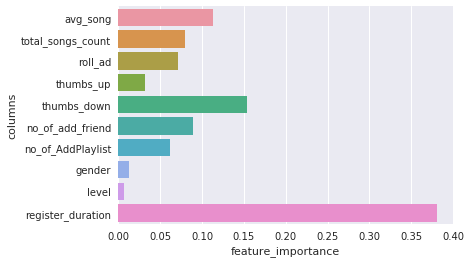

In [78]:
# Best Model: Random Forrest Model without tuning hyperparameter's
feature_list = list(["avg_song", "total_songs_count", "roll_ad", "thumbs_up","thumbs_down", "no_of_add_friend", "no_of_AddPlaylist", "gender", "level","register_duration"])
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn', seed=42)
rf_model = rf_best.fit(train)

feature_importances = rf_model.featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': feature_list})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)



The number of days a user is active on the service is the most important contributing factor of user churning. Level and gender feature is the least important.


## Summary

This project started with mini (128MB) dataset and observed there there are only 225 unique users. Cleaned the dataset and derived few useful features from the dataset. Using 3 different machine learning models Logistic Regression, Random Forest and Gradient-Boosted Tree I performed churn prediction and evaluated the model using evaluation metrics- f1 score and accuracy to pick best model. After looking at their f1 score Random Forest model performed the best with f1 score of 0.96. Finally, tuned best random forest model and calculated metrics but no improvement compared to old model without tuning.

## Future Improvements
Run model with full dataset, additional model tuning, more feature engineering to identify features can be implemented in future to enhance the model.


## Reflection
From this project I have learned how to manipulate datasets with Spark to engineer relevant features for predicting churn. I used Spark MLib to build machine learning models to predict churn. It was interesting to start with a dataset which had the customers' user interactions and then use this to predict whether or not they were likely to churn. The best model was the Random Forest classifier which achieved an accuracy and F1 score of 0.96. Interesting thing is tuned best model performed worst compared to all three models without tuning.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.